# Модуль 11. **Підбір гіперпараметрів НМ**

In [15]:
import copy

import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    GRU,
    SimpleRNN,
    Dense,
    GlobalMaxPool1D,
    Dropout,
)
import pandas as pd

     Загальні параметри для тренування моделей 

In [ ]:
# керування виводом даних
verbose = 1
summary = False


# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 8,
    "skip_top": 10,
    "batch_size": 16,
    "dropout_rate": 0.2,
    "loss_function": "binary_crossentropy",
    "optimizer": "rmsprop",
    "hidden_units": 128,
    "activation": "sigmoid",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [5, 6, 7, 8],
    # "epochs": [10, 20, 50, 100],
    "batch_size": [16, 32, 64],
    # "batch_size": [8, 32, 64, 128, 256],
    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "loss_function": [
        # "sparse_categorical_crossentropy",
        "binary_crossentropy",
        # "mean_squared_error",
    ],
    "optimizer": ["adamw", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],
    "hidden_units": [64, 128, 256],
    # "hidden_units": [32, 64, 128, 256],
    "activation": ["relu", "sigmoid"],
    # "activation": ["relu", "sigmoid", "tanh"],
    "skip_top": [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "metrics": [
        "accuracy",
    ],
}

In [16]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
CYAN = "\033[36m"
RESET = "\033[0m"

### Завдання



### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [17]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [18]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

     Функція завантаження даних 

In [19]:
def load_data(skip_top, max_features=10000, maxlen=500, verbose=0):
    # Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів
    (input_train, y_train), (input_test, y_test) = imdb.load_data(
        num_words=max_features, skip_top=skip_top
    )
    # Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів
    input_train = pad_sequences(input_train, maxlen=maxlen)
    input_test = pad_sequences(input_test, maxlen=maxlen)

    if verbose:
        print('-'*15, ' Завантаження даних ', '-'*15)
        print(f"{input_train.shape = },     {y_train.shape = }")
        print(f" {input_test.shape = },      {y_test.shape = }")
        print('-'*50)
    return input_train, y_train, input_test, y_test

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [20]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [21]:
def train_model(
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    skip_top,
    verbose=0,
    summary=0,
):

    train_images, train_labels, test_images, test_labels = load_data(skip_top, verbose=verbose)

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, ' . ', CYAN, train_loss, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, ' . ', CYAN, test_loss, RESET)

    return history, test_acc

     Функція пошуку оптимальних параметрів 

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [22]:
def find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_func,
    verbose=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    if verbose:
        print_parameters(optimal_parameters)

    for param in study_sequence:

        print(f"{GRAY_BACK}{'=' * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{'=' * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                model_func,
                verbose=verbose,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

***
### **Модель для тренування 1** 
***

In [24]:
# Видає помилку: 
# UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. 
# When using Sequential models, prefer using an `Input(shape)` object 
# as the first layer in the model instead.

# def model_1(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28), name="Input"),
#             layers.Dense(hidden_units, activation=activation, name="Hidden_layer"),
#             layers.Dropout(dropout_rate, name="Dropout_layer"),
#             layers.Dense(10, activation="softmax", name="Output"),
#         ]
#     )

In [25]:
# # такий варіант помилки не видає, працює так само
# # TODO розібратися
# def model_1(hidden_units, activation, dropout_rate):
#     # # Визначте вхідний шар
#     inputs = Input(shape=(28, 28), name="Input")

#     # # Додайте шари до моделі
#     x = layers.Flatten(name='Flatten')(inputs)
#     x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer")(x)
#     x = layers.Dropout(dropout_rate, name="Dropout_layer")(x)
#     outputs = layers.Dense(10, activation="softmax", name="Output")(x)

#     # # Створіть модель
#     model = Model(inputs, outputs)
#     return model

In [26]:
def model_1(hidden_units, activation, dropout_rate, max_features=10000):

    title_lstm = "Long Short-Term Memory (LSTM)"

    model_lstm = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_lstm.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_lstm.add(LSTM(32))
    model_lstm.add(Dropout(dropout_rate))
    model_lstm.add(Dense(1, activation=activation))

    return model_lstm

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [27]:
study_sequence = [
    # "batch_size",
    "skip_top",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

    Пошук оптимальних параметрів для вказаної моделі 
###### model_1 - функція що досліджується

  epochs 	 :  5
  skip_top 	 :  25
  batch_size 	 :  16
  dropout_rate 	 :  0.2
  loss_function 	 :  binary_crossentropy
  optimizer 	 :  adam
  hidden_units 	 :  128
  activation 	 :  relu
  metrics 	 :  ['accuracy']
Пошук оптимального значення параметра: skip_top 
--------------------------------------------------
Тестується значення: skip_top = 10
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 78ms/step - accuracy: 0.6373 - loss: 0.7352 - val_accuracy: 0.7816 - val_loss: 0.5097
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.7944 - loss: 0.5103 - val_accuracy: 0.7932 - val_loss: 0.5180
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 81ms/step - accuracy: 0.8611 - loss: 0.3797 - val_accuracy: 0.8334 - val_loss: 0.4373
Epoch 4/5
1563/1563 ━━━━━

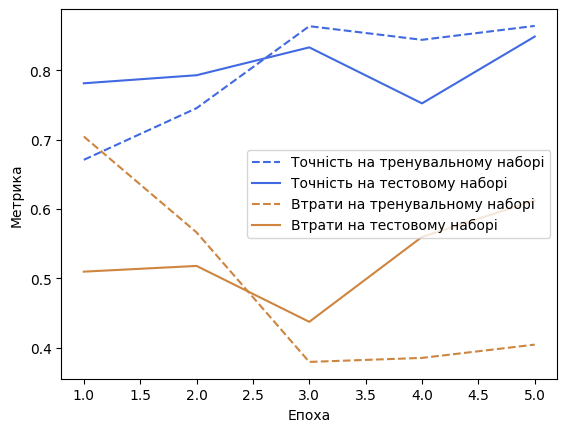

--------------------------------------------------
Тестується значення: skip_top = 50
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 86ms/step - accuracy: 0.6470 - loss: 0.7391 - val_accuracy: 0.6903 - val_loss: 0.5993
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.8251 - loss: 0.4322 - val_accuracy: 0.7385 - val_loss: 0.6074
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.8596 - loss: 0.3942 - val_accuracy: 0.8362 - val_loss: 0.5871
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.8273 - loss: 0.4392 - val_accuracy: 0.6977 - val_loss: 0.5946
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.8202 - loss: 0.4495 - val_accuracy: 0.7093 - val_loss: 0.6405
          Точність:
782/782 

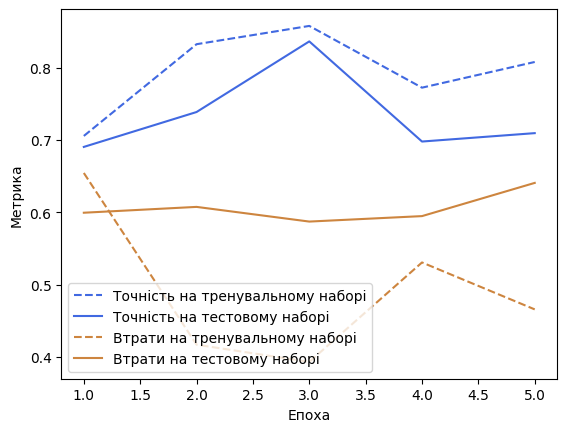

--------------------------------------------------
Тестується значення: skip_top = 100
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.6251 - loss: 0.6771 - val_accuracy: 0.7749 - val_loss: 0.5110
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 0.8097 - loss: 0.4719 - val_accuracy: 0.8428 - val_loss: 0.4719
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - accuracy: 0.7975 - loss: 0.4746 - val_accuracy: 0.8142 - val_loss: 0.4966
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 94ms/step - accuracy: 0.8755 - loss: 0.3461 - val_accuracy: 0.8395 - val_loss: 0.5155
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 89ms/step - accuracy: 0.8758 - loss: 0.4968 - val_accuracy: 0.6737 - val_loss: 0.7071
          Точність:
782/782

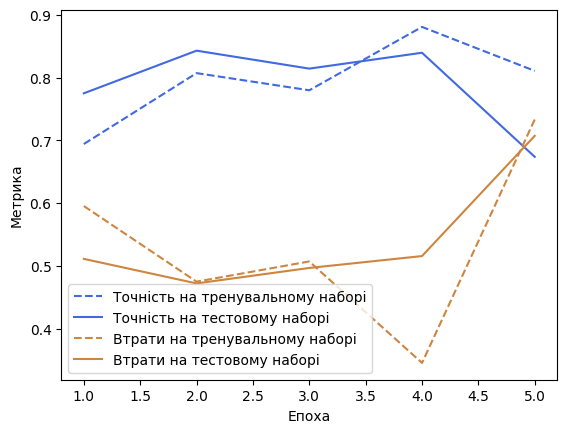

--------------------------------------------------
Тестується значення: skip_top = 250
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.4950 - loss: 8.1397 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.4989 - loss: 8.0771 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.5029 - loss: 8.0122 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.4996 - loss: 8.0654 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 100ms/step - accuracy: 0.4958 - loss: 8.1272 - val_accuracy: 0.5000 - val_loss: 8.0590
          Точність:
782/7

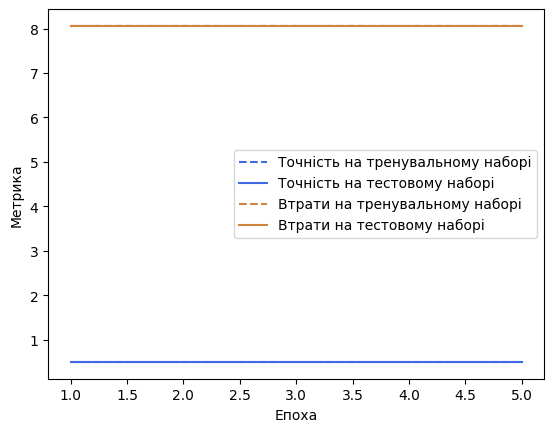

--------------------------------------------------
Тестується значення: skip_top = 500
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - accuracy: 0.5652 - loss: 0.7471 - val_accuracy: 0.6620 - val_loss: 0.6311
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 94ms/step - accuracy: 0.7608 - loss: 0.5390 - val_accuracy: 0.6503 - val_loss: 0.6227
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 98ms/step - accuracy: 0.7665 - loss: 0.5267 - val_accuracy: 0.7361 - val_loss: 0.5832
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.8608 - loss: 0.4572 - val_accuracy: 0.7390 - val_loss: 0.7068
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.8949 - loss: 0.3298 - val_accuracy: 0.8187 - val_loss: 0.6346
          Точність:
782/78

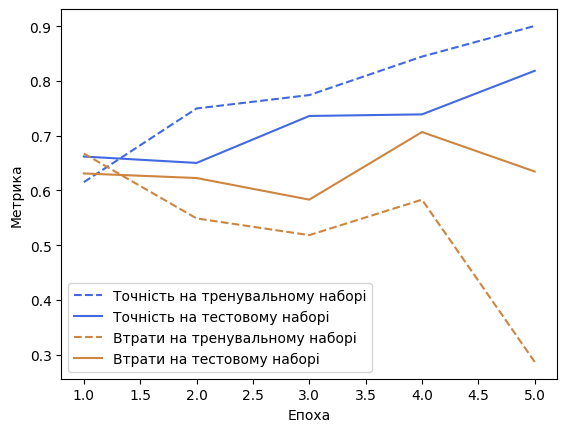

--------------------------------------------------
Тестується значення: skip_top = 1000
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.5439 - loss: 0.7983 - val_accuracy: 0.6877 - val_loss: 0.6146
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.6672 - loss: 0.6893 - val_accuracy: 0.7510 - val_loss: 0.5323
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.7816 - loss: 0.4790 - val_accuracy: 0.5451 - val_loss: 0.9184
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.7788 - loss: 0.4966 - val_accuracy: 0.7412 - val_loss: 0.6946
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 94ms/step - accuracy: 0.7564 - loss: 0.8529 - val_accuracy: 0.5913 - val_loss: 0.7311
          Точність:
782/7

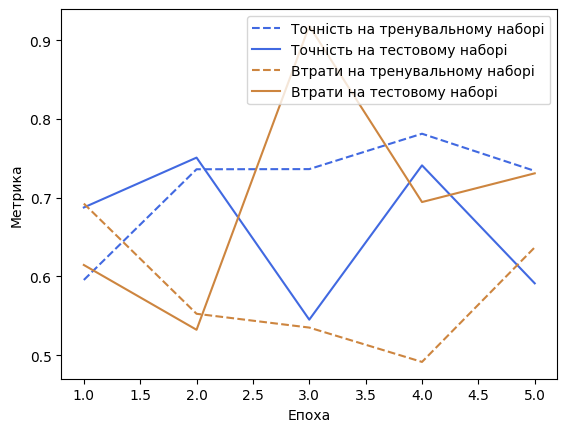

 Оптимальне значення параметра skip_top = 10
   точність на тестових даних: 0.8489599823951721

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 159s 101ms/step - accuracy: 0.6583 - loss: 0.7262 - val_accuracy: 0.5269 - val_loss: 0.7887
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.7635 - loss: 0.4992 - val_accuracy: 0.7830 - val_loss: 0.5108
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.8133 - loss: 0.4566 - val_accuracy: 0.7470 - val_loss: 0.5766
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.8474 - loss: 0.4157 - val_accuracy: 0.7661 - val_loss: 0.5234
Epoch 5/5

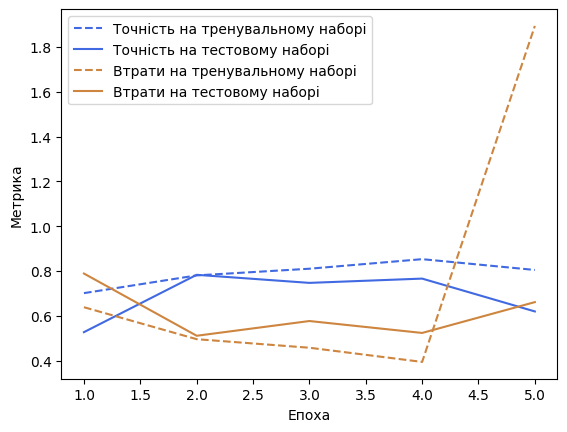

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 100ms/step - accuracy: 0.4974 - loss: 8.0003 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.5013 - loss: 7.9507 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 104ms/step - accuracy: 0.4966 - loss: 8.0256 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.4995 - loss: 7.9792 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 153s 98ms/step - accuracy: 0.5045 - loss: 7.8993 - val_accuracy: 0.5000 - val_loss: 7.9712
          Точність:
782/

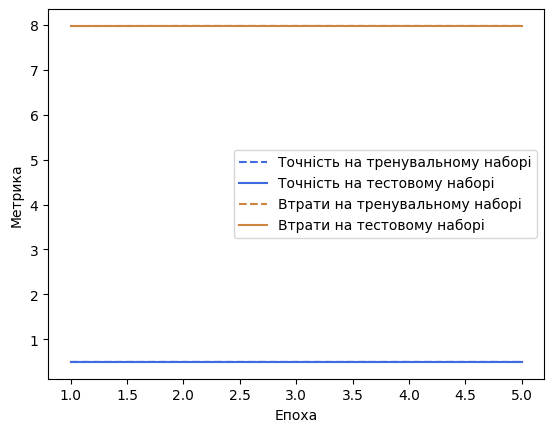

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 153s 97ms/step - accuracy: 0.7112 - loss: 0.6635 - val_accuracy: 0.8572 - val_loss: 0.3643
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.8595 - loss: 0.4137 - val_accuracy: 0.8719 - val_loss: 0.3632
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.8825 - loss: 0.4097 - val_accuracy: 0.8526 - val_loss: 0.8670
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.8984 - loss: 0.4017 - val_accuracy: 0.8616 - val_loss: 0.3859
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.9058 - loss: 0.3519 - val_accuracy: 0.8741 - val_loss: 0.3763
          Точність:
78

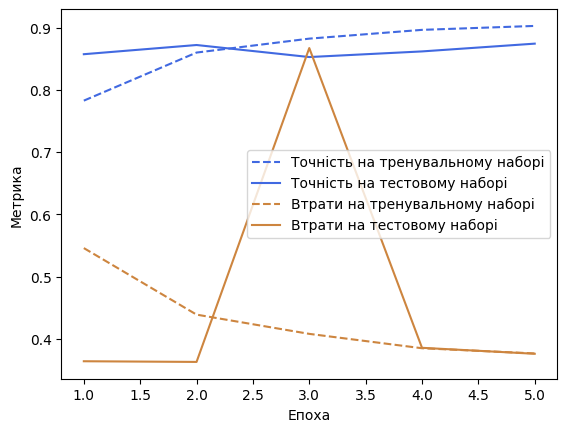

 Оптимальне значення параметра optimizer = rmsprop
   точність на тестових даних: 0.8741199970245361

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 103ms/step - accuracy: 0.7077 - loss: 0.6685 - val_accuracy: 0.8614 - val_loss: 0.4264
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 103ms/step - accuracy: 0.8522 - loss: 0.4660 - val_accuracy: 0.8547 - val_loss: 0.3754
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 155s 99ms/step - accuracy: 0.8851 - loss: 0.3769 - val_accuracy: 0.8812 - val_loss: 0.4855
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 96ms/step - accuracy: 0.8964 - loss: 0.3665 - val_accuracy: 0.7814 - val_loss: 0.4873
E

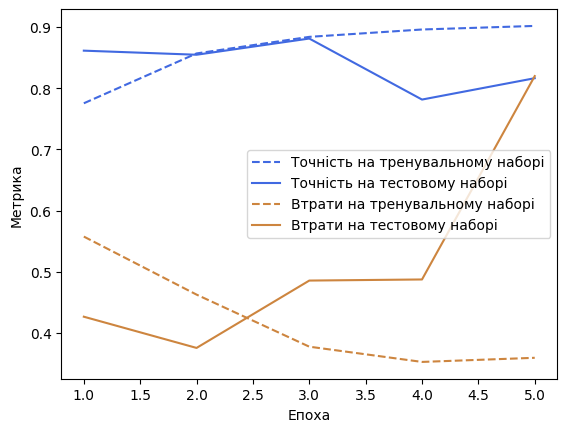

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 153s 97ms/step - accuracy: 0.6931 - loss: 0.5565 - val_accuracy: 0.8489 - val_loss: 0.3510
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.8711 - loss: 0.3211 - val_accuracy: 0.8584 - val_loss: 0.3315
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.8987 - loss: 0.2645 - val_accuracy: 0.8889 - val_loss: 0.2999
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - accuracy: 0.9153 - loss: 0.2267 - val_accuracy: 0.8796 - val_loss: 0.2881
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.9242 - loss: 0.2042 - val_accuracy: 0.8785 - val_loss: 0.3139
          Точність:
7

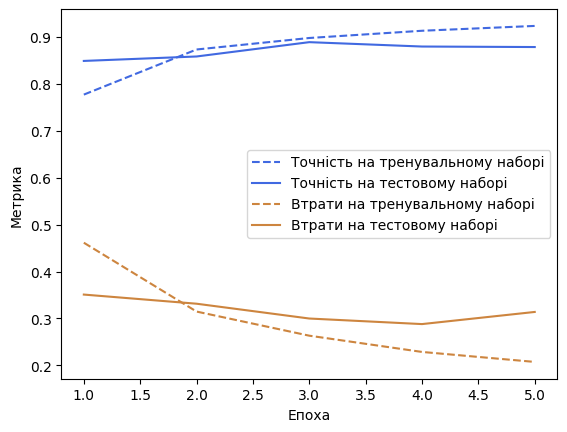

 Оптимальне значення параметра activation = sigmoid
   точність на тестових даних: 0.8784800171852112

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 8
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.6924 - loss: 0.5540 - val_accuracy: 0.8718 - val_loss: 0.3124
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.8656 - loss: 0.3227 - val_accuracy: 0.8800 - val_loss: 0.2883
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.8920 - loss: 0.2764 - val_accuracy: 0.8872 - val_loss: 0.2787
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 97ms/step - accuracy: 0.9108 - loss: 0.2365 - val_accuracy: 0.8884 - val_loss: 0.2736
Epoch 5/8
15

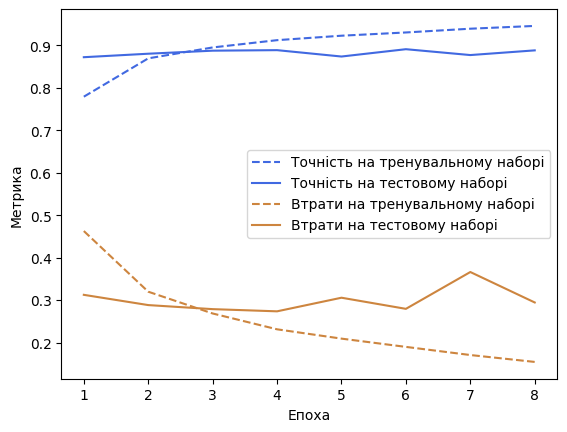

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 102ms/step - accuracy: 0.7111 - loss: 0.5451 - val_accuracy: 0.8694 - val_loss: 0.3033
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.8692 - loss: 0.3234 - val_accuracy: 0.8685 - val_loss: 0.3158
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 90ms/step - accuracy: 0.8953 - loss: 0.2621 - val_accuracy: 0.8820 - val_loss: 0.3083
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.9119 - loss: 0.2325 - val_accuracy: 0.8916 - val_loss: 0.2769
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2588s 2s/step - accuracy: 0.9261 - loss: 0.1976 - val_accuracy: 0.8903 - val_loss: 0.2726
Epoch 6/10
1563/1563 ━━━━

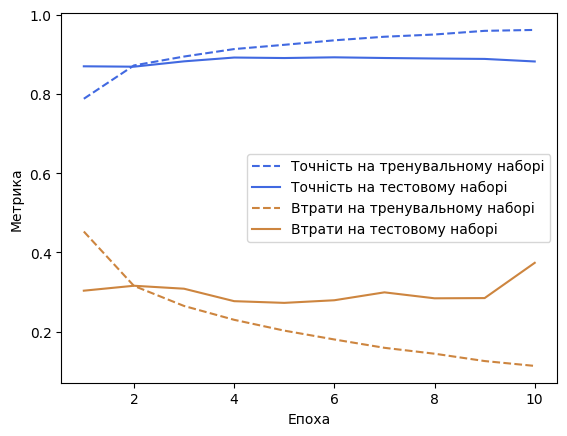

--------------------------------------------------
Тестується значення: epochs = 15
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.7019 - loss: 0.5459 - val_accuracy: 0.8136 - val_loss: 0.4131
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.8679 - loss: 0.3229 - val_accuracy: 0.8704 - val_loss: 0.3198
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.8915 - loss: 0.2734 - val_accuracy: 0.8784 - val_loss: 0.2970
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.9110 - loss: 0.2366 - val_accuracy: 0.8889 - val_loss: 0.2809
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.9240 - loss: 0.2067 - val_accuracy: 0.8828 - val_loss: 0.3039
Epoch 6/15
1563/1563 ━━

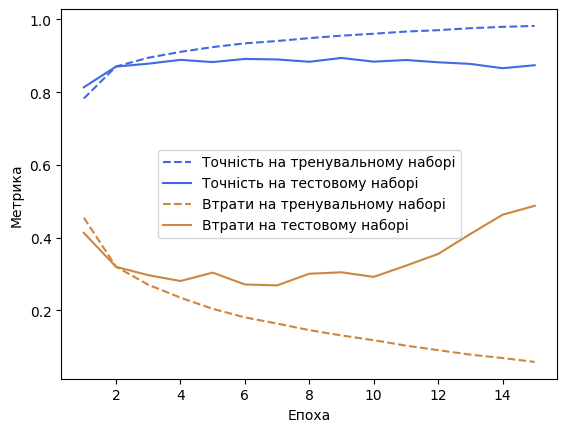

 Оптимальне значення параметра epochs = 8
   точність на тестових даних: 0.8878800272941589



In [28]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
    verbose=verbose,
    summary=summary,
)

In [29]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 8
 skip_top 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= binary_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']
 Точність:        0.8878800272941589


<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі (<b>89.68%</b>) недостатня</p>
</div>

***
### **Модель для тренування 2** 
***


In [30]:
# def model_2(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28)),
#             layers.Dense(hidden_units, activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 2), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 4), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(10, activation="softmax"),
#         ]
#     )

In [31]:
def model_2(hidden_units, activation, dropout_rate, max_features=10000):

    title_gru = "Gated Recurrent Unit (GRU)"

    model_gru = Sequential()
    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model_gru.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово
    model_gru.add(GRU(32))
    model_gru.add(Dropout(dropout_rate))
    model_gru.add(Dense(1, activation=activation))

    return model_gru

In [32]:
study_sequence = [
    # "batch_size",
    "skip_top",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

  epochs 	 :  8
  skip_top 	 :  10
  batch_size 	 :  16
  dropout_rate 	 :  0.2
  loss_function 	 :  binary_crossentropy
  optimizer 	 :  rmsprop
  hidden_units 	 :  128
  activation 	 :  sigmoid
  metrics 	 :  ['accuracy']
Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 182s 58ms/step - accuracy: 0.7233 - loss: 0.5232 - val_accuracy: 0.8700 - val_loss: 0.3194
Epoch 2/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 180s 57ms/step - accuracy: 0.8675 - loss: 0.3242 - val_accuracy: 0.8630 - val_loss: 0.3211
Epoch 3/8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 179s 57ms/step - accuracy: 0.8942 - loss: 0.2702 - val_accuracy: 0.8870 - val_loss: 0.3058
Epoch 4/8
3125/3

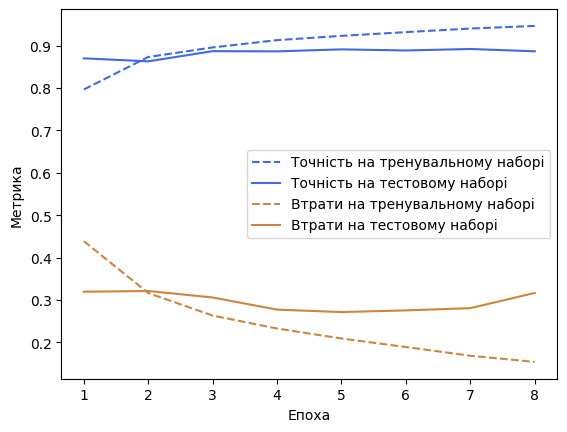

--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 82ms/step - accuracy: 0.6977 - loss: 0.5476 - val_accuracy: 0.7160 - val_loss: 0.5423
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.8711 - loss: 0.3168 - val_accuracy: 0.8312 - val_loss: 0.3959
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.8997 - loss: 0.2578 - val_accuracy: 0.8815 - val_loss: 0.3169
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.9141 - loss: 0.2276 - val_accuracy: 0.8911 - val_loss: 0.2715
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - accuracy: 0.9285 - loss: 0.1885 - val_accuracy: 0.8840 - val_loss: 0.2927
Epoch 6/8
1563/1563 ━━━━━━

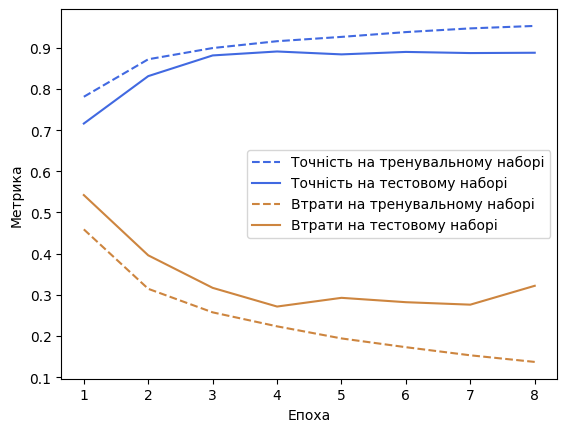

--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
input_train.shape = (25000, 500)
    y_train.shape = (25000,)
 input_test.shape = (25000, 500)
     y_test.shape = (25000,)
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/8
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 206ms/step - accuracy: 0.5746 - loss: 0.6717 - val_accuracy: 0.7505 - val_loss: 0.5252
Epoch 2/8
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 222ms/step - accuracy: 0.7761 - loss: 0.4784 - val_accuracy: 0.8422 - val_loss: 0.3682
Epoch 3/8
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 216ms/step - accuracy: 0.8397 - loss: 0.3790 - val_accuracy: 0.8477 - val_loss: 0.3685
Epoch 4/8
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.8599 - loss: 0.3382 - val_accuracy: 0.8478 - val_loss: 0.3562
Epoch 5/8
196/196 ━━━━━━━━━━━━━━━━━━━━ 50s 257ms/step - accuracy: 0.8771 - loss: 0.2964 - val_accuracy: 0.8674 - val_loss: 0.3191
Epoch 6/8
196/196 ━━━━━━━━━━━━━━━━━

In [33]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
    verbose=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>89.68%</b> до <b>90.27%</b></p>
<p>Оптимальні параметри змінилися тільки в одному пункті: <br>
 - hidden_units було 256 стало 512</p>
</div>